# QOSF Mentorship Screening Task 2


### Author
Tony Tong 

### Question
Task 2
Implement a circuit that returns |01> and |10> with equal probability.
Requirements :
The circuit should consist only of CNOTs, RXs and RYs. 
Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
Simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

#### Bonus
How to make sure you produce state |01> + |10> and not |01> - |10> ?

(Actually for more careful readers, the “correct” version of this question is posted below:
How to make sure you produce state  |01⟩  +  |10⟩  and not any other combination of |01> + e(i*phi)|10⟩ (for example |01⟩  -  |10⟩)?)

## Answer Summary

### Introduction
In a general 2-qubit system
$$|\psi\rangle=\alpha|00\rangle+\beta|01\rangle+\gamma|10\rangle+\delta|11\rangle$$

$$\left|\beta\right|^{2} = \left|\gamma\right|^{2} = 0.5$$


So in order to satisfy $\left|\beta\right|^{2} = \left|\gamma\right|^{2} = 0.5$:

$$q_1 = | 0 \rangle, q_2 = | 1 \rangle$$ $$q_1 = | 1 \rangle, q_2 = | 1 \rangle$$

When measuring in Z basis:
$$\langle 0| \sigma_z  | 0 \rangle = 1$$
$$\langle 1| \sigma_z  | 1 \rangle = -1$$


### Parametrized Models
Three parametrized quantum circuits (PQC) with different optimization methods, namely Rotosolve, Rotoselect [1] and QGAN [2], will be explored.

#### Rotosolve
Rotosolve will optimize a given parameters for a given circuit ansatz. The circuit ansatz chosen is made of 2 layers of single qubit Pauli-Y/X rotation and a CNOT block to entangle the 2 qubits so that it is expressible enough while having resonable noise.

#### Rotoselect
Rotoselect builds on the Rotosolve algorithm, now the choice of the parametric gates themselves (Rx, Ry in our case) can also be optimized.

#### Loss fucntion for Rotosolve and Rotoselect
Since $q_1, q_2$ cancels each other in Z basis, we can choose our loss function for the opimizing algorithms:
$$L = |\langle q_1| \sigma_z  | q_1 \rangle + \langle q_2| \sigma_z  | q_2 \rangle|$$

#### QGAN

### Metric
To evaluate the accuracy and the stability of the optimization methods, two metrics will be used:
1. The standard deviation of loss after 10 iterations
2. Mean squared error = $\frac{1}{2}[(\left|\beta\right|^{2} - 0.5)^2 + (\left|\gamma\right|^{2} - 0.5)^2]$

Note the second metric access the information in the state vector directly and thus is only possible to get in simulation.


### References
[1] M. Ostaszewski, E. Grant, and M. Benedetti, Quantum Circuit Structure Learning, ArXiv:1905.09692 [Quant-Ph] (2019).

[2] C. Zoufal, A. Lucchi, and S. Woerner, Quantum Generative Adversarial Networks for Learning and Loading Random Distributions, Npj Quantum Inf 5, 103 (2019).

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
%matplotlib inline

n_wires = 2

dev = qml.device("default.qubit", wires=2)

### Rotosolve
Rotosolve will optimize a given parameters for a given circuit ansatz. The circuit ansatz chosen is made of 2 layers of single qubit Pauli-Y/X rotation and a CNOT block to entangle the 2 qubits so that it is expressible enough while having resonable noise.

In [2]:
def opt_theta(d, params, cost):
    params[d] = 0.0
    M_0 = cost(params)
    params[d] = np.pi / 2.0
    M_0_plus = cost(params)
    params[d] = -np.pi / 2.0
    M_0_minus = cost(params)
    a = np.arctan2(
        2.0 * M_0 - M_0_plus - M_0_minus, M_0_plus - M_0_minus
    )  # returns value in (-pi,pi]
    params[d] = -np.pi / 2.0 - a
    # restrict output to lie in (-pi,pi], a convention
    # consistent with the Rotosolve paper
    if params[d] <= -np.pi:
        params[d] += 2 * np.pi
        
# one cycle of rotosolve
def rotosolve_cycle(cost, params):
    for d in range(len(params)):
        opt_theta(d, params, cost)
    return params

In [3]:
def ansatz(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(params[2], wires=1)
    qml.RX(params[3], wires=0)

@qml.qnode(dev)
def circuit(params):
    ansatz(params)
    return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
    
def cost(params):
    m = circuit(params)
    return np.sum(np.abs(m[0] + m[1]))

In [4]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [5]:
def fit(n_steps, n_measurements=1000, dev=dev):
    dev.shots = n_measurements
    # initial parameters are randomly chosen according to a normal curve
    init_params = list(get_truncated_normal(0,1,-np.pi,np.pi).rvs(4))
    params_rsol = init_params.copy()
    costs_rotosolve = []

    for i in range(n_steps):
        costs_rotosolve.append(cost(params_rsol))
        params_rsol = rotosolve_cycle(cost, params_rsol)
    
    return params_rsol, costs_rotosolve

def plot_loss(n_steps, costs, titlex):
    steps = np.arange(0, n_steps)
    plt.plot(steps, costs, "o-")
    plt.title(titlex)
    plt.xlabel("iterations")
    plt.ylabel("loss")
    plt.tight_layout()
    plt.show()

In [6]:
def peek(dev=dev):
    print("Take a peek at the wavefunctions (only available in simulation; not possible in real world):")
    print("--------------------------------------------------------------------------------")
    for i,j in enumerate(dev.state):
        print("\psi_{} = {}".format(i,j), end="\t")
        print("\prob_{} = {}".format(i,abs(j)**2))
    print("--------------------------------------------------------------------------------")

def report_metric(costs, dev=dev):
    long_stdev = np.std(np.array(costs)[9:])
    p_b, p_r = abs(dev.state[1])**2, abs(dev.state[2])**2
    mse = 1/2*((p_b-0.5)**2 + (p_r-0.5)**2)
    print("The standard deviation of loss after 10 iterations is: {}".format(long_stdev))
    print("The mean squared error of the probabilities is: {}".format(mse))
    return long_stdev, mse

In [7]:
np.random.seed(25)
metrics = []

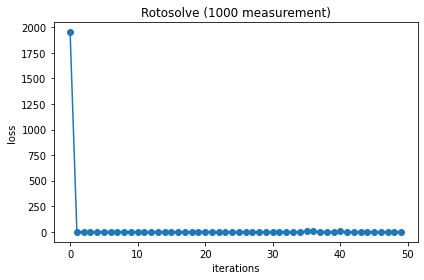

Learned parameters of the gates:  [tensor(-1.54834303, requires_grad=True), tensor(-3.04948454, requires_grad=True), tensor(-1.04461692, requires_grad=True), tensor(-1.06602701, requires_grad=True)]
Take a peek at the wavefunctions (only available in simulation; not possible in real world):
--------------------------------------------------------------------------------
\psi_0 = (0.01707318258797874+0j)	\prob_0 = 0.00029149356368246045
\psi_1 = (-0.7384989311135223+0j)	\prob_1 = 0.5453806712558149
\psi_2 = -0.6740373475259798j	\prob_2 = 0.4543263458598584
\psi_3 = 0.0012203772548753378j	\prob_3 = 1.4893206442170651e-06
--------------------------------------------------------------------------------
The standard deviation of loss after 10 iterations is: 1.5332910873660208
The mean squared error of the probabilities is: 0.0020727440030708084


In [8]:
# 1000 measurement per step
params_rsol, costs = fit(50, 1000)
plot_loss(50, costs, "Rotosolve (1000 measurement)")
print("Learned parameters of the gates: ", params_rsol)
m = circuit(params_rsol)
peek(dev)
metricx = report_metric(costs, dev)
metrics.append(metricx)

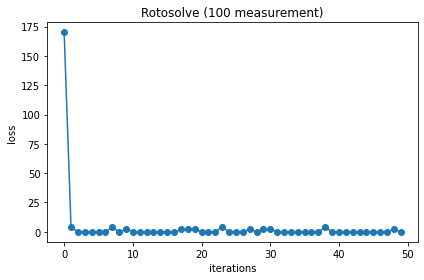

Learned parameters of the gates:  [tensor(-0.78539816, requires_grad=True), tensor(-2.81279996, requires_grad=True), tensor(-0.5203553, requires_grad=True), tensor(-0.42019671, requires_grad=True)]
Take a peek at the wavefunctions (only available in simulation; not possible in real world):
--------------------------------------------------------------------------------
\psi_0 = (-0.013687363754675552+0j)	\prob_0 = 0.00018734392655280602
\psi_1 = (-0.9322990315708292+0j)	\prob_1 = 0.8691814842679059
\psi_2 = -0.359465703750828j	\prob_2 = 0.12921559217307801
\psi_3 = -0.03762418945921847j	\prob_3 = 0.0014155796324631664
--------------------------------------------------------------------------------
The standard deviation of loss after 10 iterations is: 1.1037764389253426
The mean squared error of the probabilities is: 0.13688802270690764


In [9]:
# 100 measurement per step
params_rsol, costs = fit(50, 100)
plot_loss(50, costs, "Rotosolve (100 measurement)")
print("Learned parameters of the gates: ", params_rsol)
m = circuit(params_rsol)
peek(dev)
metricx = report_metric(costs, dev)
metrics.append(metricx)

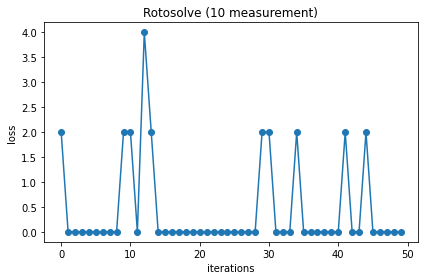

Learned parameters of the gates:  [tensor(-0.64350111, requires_grad=True), tensor(2.35619449, requires_grad=True), tensor(0.92729522, requires_grad=True), tensor(0.5880026, requires_grad=True)]
Take a peek at the wavefunctions (only available in simulation; not possible in real world):
--------------------------------------------------------------------------------
\psi_0 = (-0.004324373225115301+0j)	\prob_0 = 1.8700203790094108e-05
\psi_1 = (0.9749210730178406+0j)	\prob_1 = 0.9504710986142577
\psi_2 = 0.21779109218886678j	\prob_2 = 0.047432959836819465
\psi_3 = -0.04557676321474141j	\prob_3 = 0.0020772413451326057
--------------------------------------------------------------------------------
The standard deviation of loss after 10 iterations is: 0.9658043840596746
The mean squared error of the probabilities is: 0.2038705682643991


In [10]:
# 10 measurement per step
params_rsol, costs = fit(50, 10)
plot_loss(50, costs, "Rotosolve (10 measurement)")
print("Learned parameters of the gates: ", params_rsol)
m = circuit(params_rsol)
peek(dev)
metricx = report_metric(costs, dev)
metrics.append(metricx)

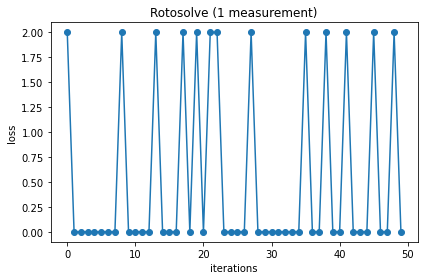

Learned parameters of the gates:  [tensor(2.35619449, requires_grad=True), tensor(-1.57079633, requires_grad=True), tensor(-1.57079633, requires_grad=True), tensor(0., requires_grad=True)]
Take a peek at the wavefunctions (only available in simulation; not possible in real world):
--------------------------------------------------------------------------------
\psi_0 = (5.551115123125783e-17+0j)	\prob_0 = 3.0814879110195774e-33
\psi_1 = (-0.38268343236508984+0j)	\prob_1 = 0.1464466094067263
\psi_2 = 0j	\prob_2 = 0.0
\psi_3 = -0.9238795325112867j	\prob_3 = 0.8535533905932737
--------------------------------------------------------------------------------
The standard deviation of loss after 10 iterations is: 0.8861415670529244
The mean squared error of the probabilities is: 0.1875


In [11]:
# Now we explore how the number of measurements can affect our algorithm
# 1 measurement per step
params_rsol, costs = fit(50, 1)
plot_loss(50, costs, "Rotosolve (1 measurement)")
print("Learned parameters of the gates: ", params_rsol)
m = circuit(params_rsol)
peek(dev)
metricx = report_metric(costs, dev)
metrics.append(metricx)

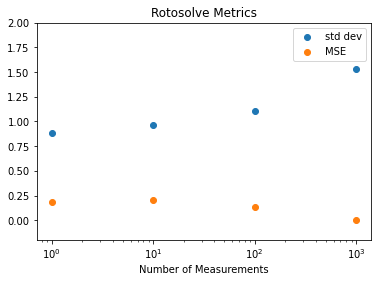

In [12]:
# Now we compare the performance across models with different measurements
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set(ylim=(-0.2,2))
ax.scatter([1,10,100,1000],np.array(metrics)[:,0][::-1], label="std dev")
ax.scatter([1,10,100,1000],np.array(metrics)[:,1][::-1], label="MSE")
ax.legend(loc="upper right")
ax.set_title("Rotosolve Metrics")
ax.set_xlabel("Number of Measurements")
plt.show()

The more mesurements taken per iteration during the optimization, the more accurate the result would be as the lower MSE suggests. On the other hand, thre more measurements, the higher the standard deviation of loss after 10 iterations would be, mostly becuase the range of the loss functions are exponentially different. The more measurements, the larger the range would be. However, looking at the loss plots, we can see that the Rotosolve is generally very stable after a few iterations with measurements larger than 100.

### Rotoselect
Rotoselect builds on the Rotosolve algorithm, now the choice of the parametric gates themselves (Rx, Ry in our case) can also be optimized.

In [13]:
def rotosolve(d, params, generators, cost, M_0):  # M_0 only calculated once
    params[d] = np.pi / 2.0
    M_0_plus = cost(params, generators)
    params[d] = -np.pi / 2.0
    M_0_minus = cost(params, generators)
    a = np.arctan2(
        2.0 * M_0 - M_0_plus - M_0_minus, M_0_plus - M_0_minus
    )  # returns value in (-pi,pi]
    params[d] = -np.pi / 2.0 - a
    if params[d] <= -np.pi:
        params[d] += 2 * np.pi
    return cost(params, generators)


def optimal_theta_and_gen_helper(d, params, generators, cost):
    params[d] = 0.0
    M_0 = cost(params, generators)  # M_0 independent of generator selection
    for generator in ["X", "Y"]:
        generators[d] = generator
        params_cost = rotosolve(d, params, generators, cost, M_0)
        # initialize optimal generator with first item in list, "X", and update if necessary
        if generator == "X" or params_cost <= params_opt_cost:
            params_opt_d = params[d]
            params_opt_cost = params_cost
            generators_opt_d = generator
    return params_opt_d, generators_opt_d


def rotoselect_cycle(cost, params, generators):
    for d in range(len(params)):
        params[d], generators[d] = optimal_theta_and_gen_helper(d, params, generators, cost)
    return params, generators

In [14]:
def RGen(param, generator, wires):
    if generator == "X":
        qml.RX(param, wires=wires)
    elif generator == "Y":
        qml.RY(param, wires=wires)

def ansatz_rsel(params, generators):
    RGen(params[0], generators[0], wires=0)
    RGen(params[1], generators[1], wires=1)
    qml.CNOT(wires=[0, 1])
    RGen(params[2], generators[2], wires=0)
    RGen(params[3], generators[3], wires=1)

@qml.qnode(dev)
def circuit_rsel(params, generators=None):  # generators will be passed as a keyword arg
    ansatz_rsel(params, generators)
    #return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliY(1))
    return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1)) 

def cost_rsel(params, generators):
    m = circuit_rsel(params, generators=generators)
    #return np.abs(m[0] + m[1])
    return np.sum(np.abs(m[0] + m[1]))

In [15]:
def fit_select(n_steps, n_measurements=1000, dev=dev):
    dev.shots = n_measurements
    # initial parameters are randomly chosen according to a normal curve
    init_params = list(get_truncated_normal(0,1,-np.pi,np.pi).rvs(4))
    params_rsel = init_params.copy()
    costs_rsel = []
    generators = ["X", "Y", "Y", "X"]

    for i in range(n_steps):
        costs_rsel.append(cost_rsel(params_rsel, generators))
        params_rsel, generators = rotoselect_cycle(cost_rsel, params_rsel, generators)
    
    return params_rsel, costs_rsel, generators

In [16]:
np.random.seed(10)
metrics_rsel = []

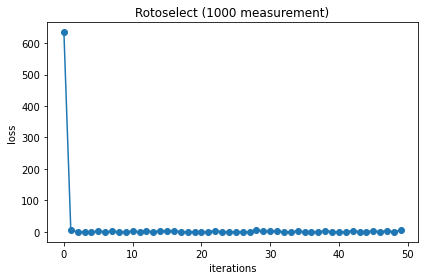

Learned generators:  ['X', 'X', 'Y', 'X']
Learned parameters of the gates:  [tensor(1.35125249, requires_grad=True), tensor(-3.12179326, requires_grad=True), tensor(0.31919791, requires_grad=True), tensor(0.29116736, requires_grad=True)]
Take a peek at the wavefunctions (only available in simulation; not possible in real world):
--------------------------------------------------------------------------------
\psi_0 = (-0.09175367573518574+0.005860773937444473j)	\prob_0 = 0.008453085682063443
\psi_1 = (0.0006971761272804726+0.7713223823528501j)	\prob_1 = 0.5949387035730288
\psi_2 = (0.6186176604819706+0.0008957512880267363j)	\prob_2 = 0.3826886122305567
\psi_3 = (-0.004700470704267786+0.11788767573206917j)	\prob_3 = 0.013919598514351168
--------------------------------------------------------------------------------
The standard deviation of loss after 10 iterations is: 1.8536585365853657
The mean squared error of the probabilities is: 0.011387659568260058


In [17]:
# 1000 measurement per step
params_rsel, costs, generators = fit_select(50, 1000)
plot_loss(50, costs, "Rotoselect (1000 measurement)")
print("Learned generators: ", generators)
print("Learned parameters of the gates: ", params_rsel)
#m = circuit_rsel(params_rsel, generators)
peek(dev)
metricx_rsel = report_metric(costs, dev)
metrics_rsel.append(metricx_rsel)

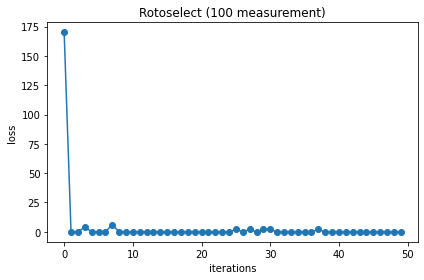

Learned generators:  ['Y', 'X', 'Y', 'Y']
Learned parameters of the gates:  [tensor(0.32175055, requires_grad=True), tensor(-3.10457254, requires_grad=True), tensor(0.06512516, requires_grad=True), tensor(-0.01999733, requires_grad=True)]
Take a peek at the wavefunctions (only available in simulation; not possible in real world):
--------------------------------------------------------------------------------
\psi_0 = (0.01825843964929379+0.004648600977424973j)	\prob_0 = 0.00035498010947422
\psi_1 = (-0.00027909588172456173+0.9863980114483903j)	\prob_1 = 0.9729811148838499
\psi_2 = (0.0006244115662974318+0.1603831623148141j)	\prob_2 = 0.02572314864390413
\psi_3 = (0.002957146238221221+0.030528865830509844j)	\prob_3 = 0.0009407563627714973
--------------------------------------------------------------------------------
The standard deviation of loss after 10 iterations is: 0.6544589202438409
The mean squared error of the probabilities is: 0.22432483338451092


In [18]:
# 100 measurement per step
params_rsel, costs, generators = fit_select(50, 100)
plot_loss(50, costs, "Rotoselect (100 measurement)")
print("Learned generators: ", generators)
print("Learned parameters of the gates: ", params_rsel)
#m = circuit_rsel(params_rsel, generators)
peek(dev)
metricx_rsel = report_metric(costs, dev)
metrics_rsel.append(metricx_rsel)

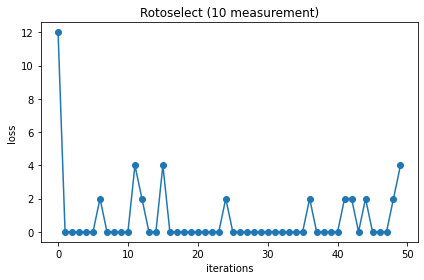

Learned generators:  ['Y', 'Y', 'Y', 'Y']
Learned parameters of the gates:  [tensor(0.32175055, requires_grad=True), tensor(0.26625205, requires_grad=True), tensor(3.14159265, requires_grad=True), tensor(-0.32175055, requires_grad=True)]
Take a peek at the wavefunctions (only available in simulation; not possible in real world):
--------------------------------------------------------------------------------
\psi_0 = (-0.046418274924777195+0j)	\prob_0 = 0.0021546562469921993
\psi_1 = (-0.15330914756710023+0j)	\prob_1 = 0.023503694727750917
\psi_2 = (0.9867074429773395+0j)	\prob_2 = 0.9735915780268797
\psi_3 = (-0.02738742409167852+0j)	\prob_3 = 0.000750070998377453
--------------------------------------------------------------------------------
The standard deviation of loss after 10 iterations is: 1.204789174168631
The mean squared error of the probabilities is: 0.22566885585804722


In [19]:
# 10 measurement per step
params_rsel, costs, generators = fit_select(50, 10)
plot_loss(50, costs, "Rotoselect (10 measurement)")
print("Learned generators: ", generators)
print("Learned parameters of the gates: ", params_rsel)
#m = circuit_rsel(params_rsel, generators)
peek(dev)
metricx_rsel = report_metric(costs, dev)
metrics_rsel.append(metricx_rsel)

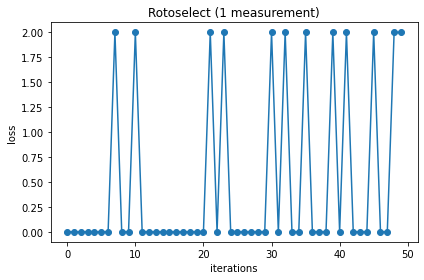

Learned generators:  ['Y', 'X', 'Y', 'Y']
Learned parameters of the gates:  [tensor(-2.35619449, requires_grad=True), tensor(-1.57079633, requires_grad=True), tensor(2.35619449, requires_grad=True), tensor(0.78539816, requires_grad=True)]
Take a peek at the wavefunctions (only available in simulation; not possible in real world):
--------------------------------------------------------------------------------
\psi_0 = (-0.13529902503654923+0.5179824574016388j)	\prob_0 = 0.28661165235168135
\psi_1 = (0.5972387912921926+0.3266407412190941j)	\prob_1 = 0.46338834764831843
\psi_2 = (0.3266407412190942-0.32664074121909414j)	\prob_2 = 0.2133883476483185
\psi_3 = (-0.13529902503654928+0.13529902503654923j)	\prob_3 = 0.03661165235168156
--------------------------------------------------------------------------------
The standard deviation of loss after 10 iterations is: 0.8861415670529244
The mean squared error of the probabilities is: 0.04174332617584077


In [20]:
# 1 measurement per step
params_rsel, costs, generators = fit_select(50, 1)
plot_loss(50, costs, "Rotoselect (1 measurement)")
print("Learned generators: ", generators)
print("Learned parameters of the gates: ", params_rsel)
#m = circuit_rsel(params_rsel, generators)
peek(dev)
metricx_rsel = report_metric(costs, dev)
metrics_rsel.append(metricx_rsel)

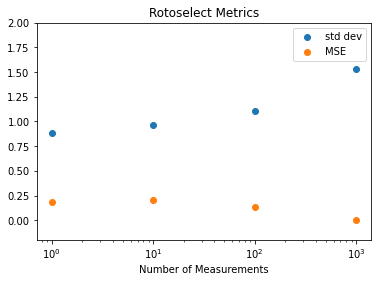

In [21]:
# Now we compare the performance across models with different measurements
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set(ylim=(-0.2,2))
ax.scatter([1,10,100,1000],np.array(metrics)[:,0][::-1], label="std dev")
ax.scatter([1,10,100,1000],np.array(metrics)[:,1][::-1], label="MSE")
ax.legend(loc="upper right")
ax.set_title("Rotoselect Metrics")
ax.set_xlabel("Number of Measurements")
plt.show()

Rotoselect's metrics behave similarly as Rotosolve's with respect to the numebr of measurements. Also note that Rotoselect's performance is about the same as Rotosolve's probably due to not enough optimization on the structure of the circuit.